In [1]:
# Stop warnings
import warnings
warnings.filterwarnings("ignore")

# Imports
import os
import sys
import time
import json
import copy
import cortex
import numpy as np
import pandas as pd
from scipy import stats
import matplotlib.pyplot as plt

# Plotly imports
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots

# Personal imports
sys.path.append("{}/../../../analysis_code/utils".format(os.getcwd()))
from plot_utils import *
from pycortex_utils import draw_cortex, set_pycortex_config_file, load_surface_pycortex, create_colormap, get_rois
from surface_utils import load_surface
from maths_utils import weighted_regression

In [2]:
# Directories
main_dir = '/Users/uriel/disks/meso_shared'
project_dir = 'RetinoMaps'

In [3]:
# General settings
with open('../../settings.json') as f:
    json_s = f.read()
    analysis_info = json.loads(json_s)
TRs = analysis_info['TRs']
subjects = analysis_info['subjects']
rois = analysis_info['rois']
rois_groups = analysis_info['rois_groups']

with open('../../figure_settings.json') as f:
    json_s = f.read()
    figure_info = json.loads(json_s)
plot_groups = figure_info['plot_groups']
fig_width = figure_info['fig_width']

In [4]:
# Set pycortex db and colormaps
cortex_dir = "{}/{}/derivatives/pp_data/cortex".format(main_dir, project_dir)
set_pycortex_config_file(cortex_dir)

port_num = 25000

In [5]:
# Template settings
template_specs = dict(axes_color="rgba(0, 0, 0, 1)",
                      axes_width=2,
                      axes_font_size=15,
                      bg_col="rgba(255, 255, 255, 1)",
                      font='Arial',
                      title_font_size=15,
                      plot_width=1.5)
fig_template = plotly_template(template_specs)
standoff = 8

In [6]:
# Plot settings
roi_colors_dict = {'V1': 'rgb(243, 231, 155)', 
                   'V2': 'rgb(250, 196, 132)', 
                   'V3': 'rgb(248, 160, 126)', 
                   'V3AB': 'rgb(235, 127, 134)', 
                   'LO': 'rgb(150, 0, 90)',  
                   'VO': 'rgb(0, 0, 200)', 
                   'hMT+': 'rgb(0, 25, 255)', 
                   'iIPS': 'rgb(0, 152, 255)', 
                   'sIPS': 'rgb(44, 255, 150)', 
                   'iPCS': 'rgb(151, 255, 0)', 
                   'sPCS': 'rgb(255, 234, 0)', 
                   'mPCS': 'rgb(255, 111, 0)'}


# pRF plots

## ECC size

### Function

In [129]:
def prf_ecc_size_plot(df_ecc_size, fig_width, fig_height, rois, roi_colors, plot_groups, max_ecc, max_size):
    """
    Make scatter plot for linear relationship between eccentricity and size

    Parameters
    ----------
    df_ecc_size : A data dataframe
    fig_width : figure width in pixels
    fig_height : figure height in pixels
    rois : list of rois
    roi_colors : list of rgb colors for plotly
    plot_groups : groups of roi to plot together
    max_ecc : maximum eccentricity 
    
    Returns
    -------
    fig : eccentricy as a function of size plot
    """
    
    from maths_utils import weighted_regression

    # General figure settings
    template_specs = dict(axes_color="rgba(0, 0, 0, 1)",
                          axes_width=2,
                          axes_font_size=15,
                          bg_col="rgba(255, 255, 255, 1)",
                          font='Arial',
                          title_font_size=15,
                          plot_width=1.5)
    
    # General figure settings
    fig_template = plotly_template(template_specs)

    # General settings
    rows, cols = 1, len(plot_groups)
    fig = make_subplots(rows=rows, cols=cols, print_grid=False)
    for l, line_label in enumerate(plot_groups):
        for j, roi in enumerate(line_label):
            
            # Parametring colors
            roi_color = roi_colors[roi]
            roi_color_opac = f"rgba{roi_color[3:-1]}, 0.15)"
            
            # Get data
            df = df_ecc_size.loc[(df_ecc_size.roi == roi)]
            ecc_median = np.array(df.prf_ecc_bins)
            size_median = np.array(df.prf_size_bins_median)
            r2_median = np.array(df.prf_loo_r2_bins_median)
            size_upper_bound = np.array(df.prf_size_bins_ci_upper_bound)
            size_lower_bound = np.array(df.prf_size_bins_ci_lower_bound)
            
            # Linear regression
            slope, intercept = weighted_regression(ecc_median, size_median, r2_median, model='linear')
            slope_upper, intercept_upper = weighted_regression(ecc_median[np.where(~np.isnan(size_upper_bound))], 
                                                               size_upper_bound[~np.isnan(size_upper_bound)], 
                                                               r2_median[np.where(~np.isnan(size_upper_bound))], 
                                                               model='linear')
            
            slope_lower, intercept_lower = weighted_regression(ecc_median[np.where(~np.isnan(size_lower_bound))], 
                                                               size_lower_bound[~np.isnan(size_lower_bound)], 
                                                               r2_median[np.where(~np.isnan(size_lower_bound))], 
                                                               model='linear')

            line_x = np.linspace(ecc_median[0], ecc_median[-1], 50)
            line = slope * line_x + intercept
            line_upper = slope_upper * line_x + intercept_upper
            line_lower = slope_lower * line_x + intercept_lower

            fig.add_trace(go.Scatter(x=line_x, y=line, mode='lines', name=roi, legendgroup=roi, 
                                      line=dict(color=roi_color, width=3), showlegend=False), 
                          row=1, col=l+1)

            # Error area
            fig.add_trace(go.Scatter(x=np.concatenate([line_x, line_x[::-1]]), 
                                      y=np.concatenate([list(line_upper), list(line_lower[::-1])]), 
                                      mode='lines', fill='toself', fillcolor=roi_color_opac, 
                                      line=dict(color=roi_color_opac, width=0), showlegend=False), 
                          row=1, col=l+1)

            # Markers
            fig.add_trace(go.Scatter(x=ecc_median, 
                                     y=size_median, mode='markers', 
                                     error_y=dict(type='data', 
                                                  array=size_upper_bound - size_median, 
                                                  arrayminus=size_median - size_lower_bound,
                                                  visible=True, 
                                                  thickness=3, 
                                                  width=0, 
                                                  color=roi_color),
                                      marker=dict(color=roi_color,
                                                  symbol='square',
                                                  size=8, 
                                                  line=dict(color=roi_color, 
                                                            width=3)), 
                                      showlegend=False), 
                          row=1, col=l + 1)
            
            # Add legend
            annotation = go.layout.Annotation(x=1, y=20-j*1.5, text=roi, xanchor='left',
                                              showarrow=False, font_color=roi_color, 
                                              font_family=template_specs['font'],
                                              font_size=template_specs['axes_font_size'],
                                             )
            fig.add_annotation(annotation, row=1, col=l+1)
            
            
        # Set axis titles only for the left-most column and bottom-most row
        fig.update_yaxes(title_text='pRF size (dva)', row=1, col=1)
        fig.update_xaxes(title_text='pRF eccentricity (dva)', range=[0, max_ecc], showline=True, row=1, col=l+1)
        fig.update_yaxes(range=[0, max_size], showline=True, tickmode="array", tickvals=np.linspace(0,max_size,4), ticktext=[str(x) for x in np.linspace(0, max_size, 4).astype(int)])
        fig.update_layout(height=fig_height, width=fig_width, showlegend=False, template=fig_template,
                         margin_l=470, margin_r=470, margin_t=50, margin_b=100)
        


        
    return fig

### Plot

In [130]:
# Settings
subject = 'group'
format_ = '170k'
suffix = 'Sac_Pur'

max_ecc = 15
max_size = 18

# tresholds
ecc_th = [0, 15]
size_th= [0.1, 20]
rsq_th = [0, 1]
pcm_th = [0,20]

plot_groups = [['iIPS', 'sIPS'],['iPCS', 'sPCS', 'mPCS']]
# plot_groups = [['iIPS', 'sIPS', 'iPCS', 'sPCS', 'mPCS'],['iIPS', 'sIPS', 'iPCS', 'sPCS', 'mPCS']]
rois = ['iIPS', 'sIPS', 'iPCS', 'sPCS', 'mPCS']

In [131]:
# Load data
intertask_all_tsv_dir ='{}/{}/derivatives/pp_data/{}/{}/intertask/tsv/tsv_vision_and_pursuit_and_saccade'.format(main_dir, project_dir, subject, format_)
df_ecc_size = pd.read_table('{}/{}_vision_and_pursuit_and_saccade_prf_ecc_size_{}.tsv'.format(intertask_all_tsv_dir,subject, suffix))



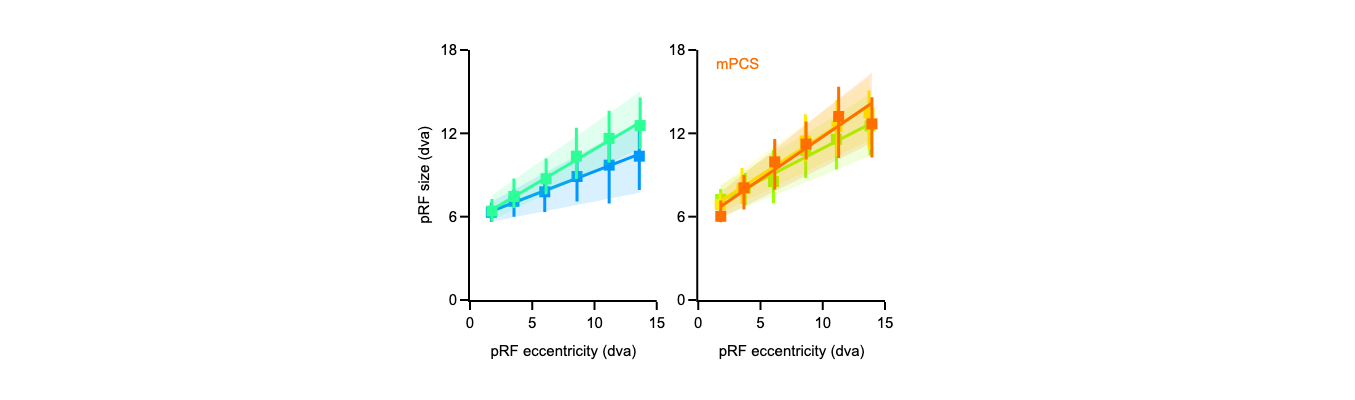

In [132]:
# Plot
fig = prf_ecc_size_plot(df_ecc_size=df_ecc_size, fig_width=fig_width, 
                        fig_height=400, rois=rois, roi_colors=roi_colors_dict,
                        plot_groups=plot_groups, max_ecc=max_ecc, max_size=max_size)

fig.show()
fig_dir = '/Users/uriel/Library/CloudStorage/Dropbox/retinomaps/figures/material/pRF_figures/ecc_size_pcm'
fig.write_image("{}/{}_ecc_size.pdf".format(fig_dir, subject))
# fig.write_image("{}/{}_ecc_size2.pdf".format(fig_dir, subject))

## ECC pCM

### function

In [12]:
def prf_ecc_pcm_plot(df_ecc_pcm, fig_width, fig_height, rois, roi_colors, plot_groups, max_ecc, max_pcm):
    """
    Make scatter plot for relationship between eccentricity and pCM

    Parameters
    ----------
    df_ecc_pcm : dataframe for the plot
    fig_width : figure width in pixels
    fig_height : figure height in pixels
    rois : list of rois
    roi_colors : list of rgb colors for plotly
    plot_groups : groups of roi to plot together
    max_ecc : maximum eccentricity
    
    Returns
    -------
    fig : eccentricy as a function of pcm plot
    """

    from maths_utils import weighted_regression
    
    # General figure settings
    template_specs = dict(axes_color="rgba(0, 0, 0, 1)",
                          axes_width=2,
                          axes_font_size=15,
                          bg_col="rgba(255, 255, 255, 1)",
                          font='Arial',
                          title_font_size=15,
                          plot_width=1.5)
    
    # General figure settings
    fig_template = plotly_template(template_specs)

    # General settings
    rows, cols = 1, len(plot_groups)
    fig = make_subplots(rows=rows, cols=cols, print_grid=False)
    for l, line_label in enumerate(plot_groups):
        for j, roi in enumerate(line_label):

            # Parametring colors
            roi_color = roi_colors[roi]
            roi_color_opac = f"rgba{roi_color[3:-1]}, 0.15)"
            
            # Get data
            df = df_ecc_pcm.loc[(df_ecc_pcm.roi == roi)]
            ecc_median = np.array(df.prf_ecc_bins)
            pcm_median = np.array(df.prf_pcm_bins_median)
            r2_median = np.array(df.prf_loo_r2_bins_median)
            pcm_upper_bound = np.array(df.prf_pcm_bins_ci_upper_bound)
            pcm_lower_bound = np.array(df.prf_pcm_bins_ci_lower_bound)
            
            # Linear regression
            slope, intercept = weighted_regression(ecc_median, pcm_median, r2_median, model='pcm')
            
            slope_upper, intercept_upper = weighted_regression(ecc_median[~np.isnan(pcm_upper_bound)], 
                                                               pcm_upper_bound[~np.isnan(pcm_upper_bound)], 
                                                               r2_median[~np.isnan(pcm_upper_bound)], 
                                                               model='pcm')
            
            slope_lower, intercept_lower = weighted_regression(ecc_median[~np.isnan(pcm_lower_bound)], 
                                                               pcm_lower_bound[~np.isnan(pcm_lower_bound)], 
                                                               r2_median[~np.isnan(pcm_lower_bound)], 
                                                               model='pcm')

            line_x = np.linspace(ecc_median[0], ecc_median[-1], 50)
            line = 1 / (slope * line_x + intercept)
            line_upper = 1 / (slope_upper * line_x + intercept_upper)
            line_lower = 1 / (slope_lower * line_x + intercept_lower)

            fig.add_trace(go.Scatter(x=line_x, 
                                     y=line, 
                                     mode='lines', 
                                     name=roi, 
                                     legendgroup=roi, 
                                     line=dict(color=roi_color, width=3), 
                                     showlegend=False), 
                          row=1, col=l+1)

            # Error area
            fig.add_trace(go.Scatter(x=np.concatenate([line_x, line_x[::-1]]),
                                      y=np.concatenate([list(line_upper), list(line_lower[::-1])]), 
                                      mode='lines', fill='toself', fillcolor=roi_color_opac, 
                                      line=dict(color=roi_color_opac, width=0), showlegend=False), 
                          row=1, col=l+1)

            # Markers
            fig.add_trace(go.Scatter(x=ecc_median, 
                                     y=pcm_median, 
                                     mode='markers', 
                                     error_y=dict(type='data', 
                                                  array=pcm_upper_bound - pcm_median, 
                                                  arrayminus=pcm_median - pcm_lower_bound,
                                                  visible=True, 
                                                  thickness=3, 
                                                  width=0, 
                                                  color=roi_color),
                                     marker=dict(color=roi_color, 
                                                 symbol='square',
                                                 size=8, line=dict(color=roi_color,
                                                                   width=3)), 
                                     showlegend=False), 
                          row=1, col=l + 1)
            
            # Add legend
            annotation = go.layout.Annotation(x=12, y=(20)-j*2, text=roi, xanchor='left',
                                              showarrow=False, font_color=roi_color, 
                                              font_family=template_specs['font'],
                                              font_size=template_specs['axes_font_size'],
                                             )
            fig.add_annotation(annotation, row=1, col=l+1)
        

        # Set axis titles only for the left-most column and bottom-most row
        fig.update_yaxes(title_text='pRF cortical magn. (mm/dva)', row=1, col=1)
        fig.update_xaxes(title_text='pRF eccentricity (dva)', range=[0, max_ecc], showline=True, row=1, col=l+1)
        fig.update_yaxes(range=[0, max_pcm], showline=True,  nticks=4)
        fig.update_layout(height=fig_height, width=fig_width, showlegend=False, template=fig_template,
                         margin_l=470, margin_r=470, margin_t=50, margin_b=100)
        
    return fig

### Plot

In [13]:
# Plot settings
roi_colors_dict = {'V1': 'rgb(235, 127, 134)', 
                   'V2': 'rgb(250, 196, 132)', 
                   'V3': 'rgb(248, 160, 126)', 
                   'V3AB': 'rgb(235, 127, 134)', 
                   'LO': 'rgb(150, 0, 90)',  
                   'VO': 'rgb(0, 0, 200)', 
                   'hMT+': 'rgb(0, 25, 255)', 
                   'iIPS': 'rgb(0, 152, 255)', 
                   'sIPS': 'rgb(44, 255, 150)', 
                   'iPCS': 'rgb(151, 255, 0)', 
                   'sPCS': 'rgb(255, 234, 0)', 
                   'mPCS': 'rgb(255, 111, 0)'}


In [14]:
# Settings
subject = 'group'
format_ = '170k'
suffix = 'Sac_Pur'

max_ecc = 15
max_pcm = 6

# tresholds
ecc_th = [0, 15]
size_th= [0.1, 20]
rsq_th = [0, 1]
pcm_th = [0,20]

plot_groups = [['iIPS', 'sIPS'],['iPCS', 'sPCS', 'mPCS']]
# plot_groups = [['V1'],['V1']]
# plot_groups = [['iIPS', 'sIPS', 'iPCS', 'sPCS', 'mPCS'],['iIPS', 'sIPS', 'iPCS', 'sPCS', 'mPCS']]
# rois = ['V1', 'V1']
rois = ['iIPS', 'sIPS', 'iPCS', 'sPCS', 'mPCS']

In [15]:
intertask_all_tsv_dir ='{}/{}/derivatives/pp_data/{}/{}/intertask/tsv/tsv_vision_and_pursuit_and_saccade'.format(main_dir, project_dir, subject, format_)
df_ecc_pcm = pd.read_table('{}/{}_vision_and_pursuit_and_saccade_prf_ecc_pcm_{}.tsv'.format(intertask_all_tsv_dir,subject, suffix))

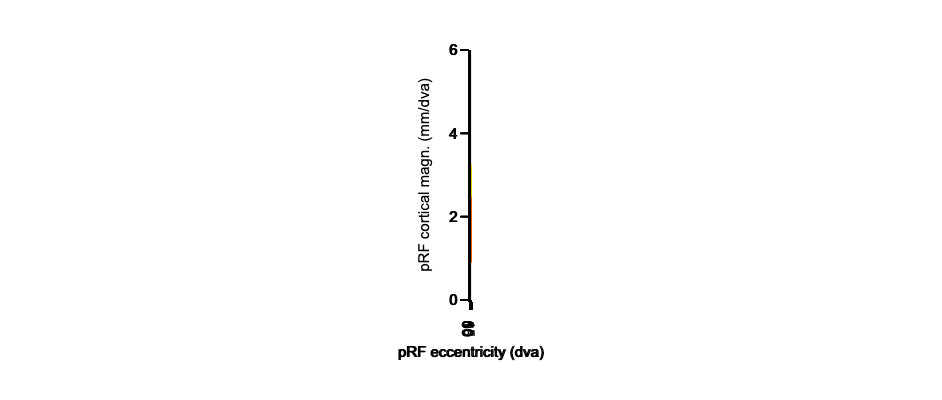

In [17]:
fig = prf_ecc_pcm_plot(df_ecc_pcm=df_ecc_pcm, fig_width=fig_width, fig_height=400, 
                        rois=rois, roi_colors=roi_colors_dict,
                        plot_groups=plot_groups, max_ecc=max_ecc, max_pcm=max_pcm)

fig.show()
fig_dir = '/Users/uriel/Library/CloudStorage/Dropbox/retinomaps/figures/material/pRF_figures/ecc_size_pcm'
fig.write_image("{}/{}_ecc_pCM.pdf".format(fig_dir, subject))


# Vertex bar plot group ROI

## Plot

In [18]:
# Specific settings
subject = 'group'
format_ = '170k'
suffix = 'Sac_Pur'

In [19]:
# Load DF 
tsv_dir = '{}/{}/derivatives/pp_data/{}/{}/intertask/tsv'.format(main_dir, project_dir, subject, format_)
active_vertex_tsv_fn = '{}/{}_active_vertex_roi_{}.tsv'.format(tsv_dir, subject, suffix)

df_active_vertex_roi = pd.read_table(active_vertex_tsv_fn)

In [20]:
plot_groups = {'frontal' : ['iPCS', 'sPCS', 'mPCS'],
               'parietal ' : ['iIPS', 'sIPS'] 
              }

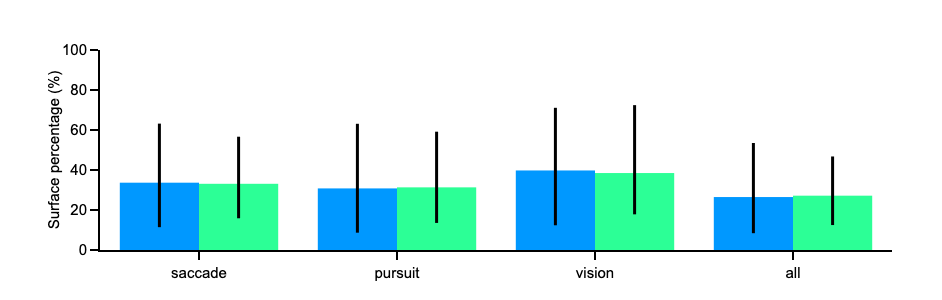

In [24]:
# sub_rois =  ['iPCS', 'sPCS', 'mPCS']
sub_rois =  ['iIPS', 'sIPS']
fig = go.Figure()
for i, roi in enumerate(sub_rois):
    df_roi = df_active_vertex_roi.loc[df_active_vertex_roi['roi']==roi]
    fig.add_trace(go.Bar(
        x=df_roi['categorie'],
        y=df_roi['median'],
        name=roi,  
        marker=dict(color=roi_colors_dict[roi]), 
        error_y=dict(
            type='data',
            array=df_roi['ci_high'] - df_roi['median'], 
            arrayminus=df_roi['median'] - df_roi['ci_low'],  
            visible=True,
            thickness=3,
            width=0,
            color='black'
        ),
        showlegend=True
    ))
    
fig.update_xaxes(showline=True)
fig.update_yaxes(title='Surface percentage (%)', range=[0,100], showline=True)
fig.update_layout(template=fig_template, 
                  barmode='group', 
                  showlegend=False,
                  height=300, 
                  width=500, 
                  margin_l=100, 
                  margin_r=50, 
                  margin_t=50,
                  margin_b=50)

fig.show()
# fig.write_image("/Users/uriel/Library/CloudStorage/Dropbox/retinomaps/figures/material/pRF_figures/active_vertex/Surface_percentage_frontal.pdf".format(subject))
fig.write_image("/Users/uriel/Library/CloudStorage/Dropbox/retinomaps/figures/material/pRF_figures/active_vertex/Surface_percentage_parietal.pdf".format(subject))

### Values

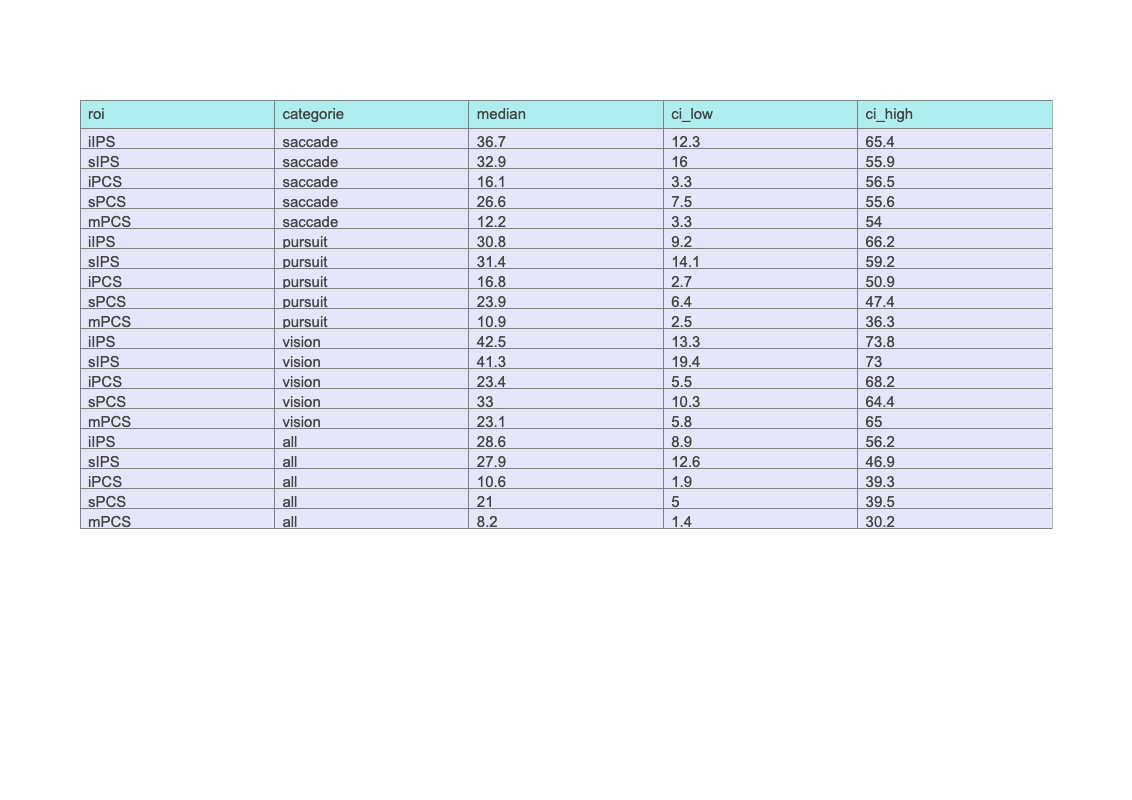

In [16]:
sub_rois =  ['iIPS', 'sIPS', 'iPCS', 'sPCS', 'mPCS']

df_roi = df_active_vertex_roi.loc[df_active_vertex_roi['roi'].isin(sub_rois)]

fig = go.Figure()
fig.add_trace(go.Table(header=dict(values=list(df_roi.columns), 
                                   fill_color='paleturquoise', 
                                   align='left'), 
                       cells=dict(values=[df_roi[col].round(1) for col in df_roi.columns], 
                                  fill_color='lavender', 
                                  align='left')
                      ))

fig.update_layout(template=fig_template,
                  height=800, 
                  width=800)
# fig.write_image("/Users/uriel/Downloads/Surface_percentage_table.pdf".format(subject))
fig.show()

# Vertex bar plot MMP ROI

## Plot

In [23]:
# Specific settings
subject = 'group'
format_ = '170k'
suffix = 'Sac_Pur'
categories = ['saccade', 'pursuit', 'vision', 'all']
plot_groups = [['iIPS', 'sIPS', ''], ['iPCS', 'sPCS', 'mPCS']]

In [24]:
# Load DF 
tsv_dir = '{}/{}/derivatives/pp_data/{}/{}/intertask/tsv'.format(main_dir, project_dir, subject, format_)
active_vertex_roi_mmp_tsv_fn = '{}/{}_active_vertex_roi_mmp_{}.tsv'.format(tsv_dir, subject, suffix)

df_active_vertex_roi_mmp = pd.read_table(active_vertex_roi_mmp_tsv_fn)

In [25]:
categorie = 'all'
fig = active_vertex_roi_mmp_plot(df_active_vertex_roi_mmp=df_active_vertex_roi_mmp, fig_height=1080, fig_width=1080, roi_colors=roi_colors_dict, plot_groups=plot_groups, categorie=categorie)


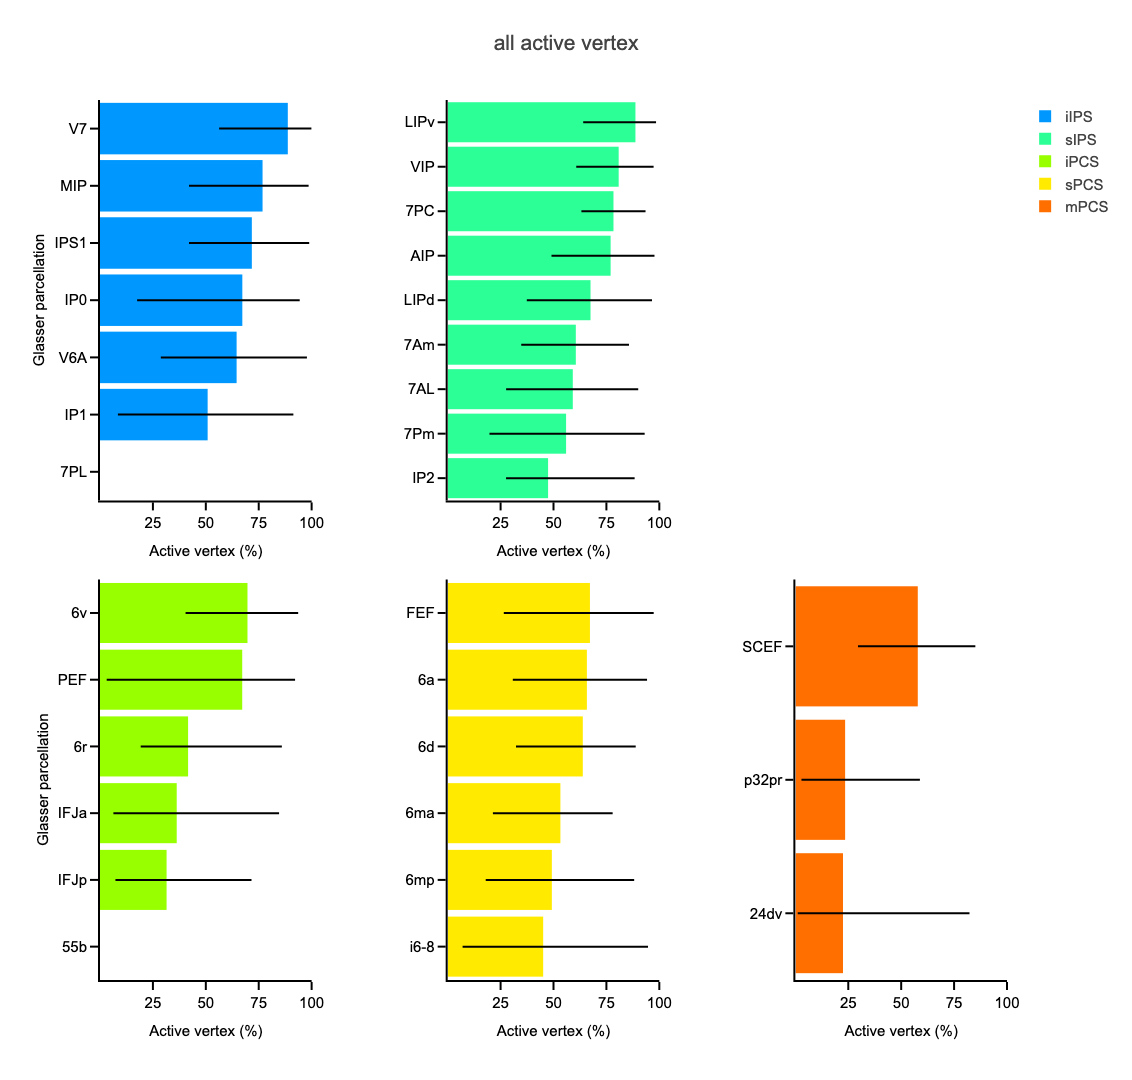

In [26]:
fig_dir = '/Users/uriel/Library/CloudStorage/Dropbox/retinomaps/figures/material/pRF_figures/active_vertex/'
fig_fn = "{}/{}_active_vertex_{}_roi_mmp_{}.pdf".format(fig_dir, subject,categorie, suffix)
fig.write_image(fig_fn)
fig.show()

### Values

In [24]:
for group in plot_groups:
    for roi in group:
        subset = df_active_vertex_roi_mmp[
            (df_active_vertex_roi_mmp['roi'] == roi) & 
            (df_active_vertex_roi_mmp['categorie'] == 'all')
        ]
        min_value = subset['median'].min(skipna=True)
        max_value = subset['median'].max(skipna=True)
        min_roi = subset.loc[subset['median'] == min_value, 'roi_mmp'].iloc[0] if not subset[subset['median'] == min_value].empty else None
        max_roi = subset.loc[subset['median'] == max_value, 'roi_mmp'].iloc[0] if not subset[subset['median'] == max_value].empty else None

        print("for {:<10} value range is [{:.2f} ({}) - {:.2f} ({})]".format(roi, min_value, min_roi, max_value, max_roi))

for iIPS       value range is [0.00 (7PL) - 87.91 (V7)]
for sIPS       value range is [49.08 (IP2) - 88.02 (LIPv)]
for            value range is [nan (None) - nan (None)]
for iPCS       value range is [0.00 (55b) - 68.41 (6v)]
for sPCS       value range is [44.49 (i6-8) - 70.85 (FEF)]
for mPCS       value range is [23.13 (24dv) - 53.93 (SCEF)]


In [32]:
df_active_vertex_roi_mmp

,roi,roi_mmp,categorie,median,ci_low,ci_high
0,V1,V1,saccade,86.675538,66.125209,96.619775
1,V2,V2,saccade,90.307573,65.340912,98.059583
2,V3,V3,saccade,86.612676,53.671859,97.313265
3,V3,V4,saccade,87.243208,59.885390,98.425845
4,V3AB,V3A,saccade,93.848348,71.108920,99.195576
...,...,...,...,...,...,...
207,sPCS,6mp,all,55.643163,21.628788,89.242799
208,sPCS,6ma,all,59.674797,24.445304,76.908086
209,mPCS,SCEF,all,55.899011,36.103201,78.790136
210,mPCS,p32pr,all,24.605294,5.095497,62.612851
